## Differentiable programming and scientific computing
Machine learning algorithms are often criticized for their poor interpretability and a lack of uncertainty quantification. They are widely used nonetheless thank to modular libraries that allow us to build flexible models and training pipelines adapted to all kinds of problems. [Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) and [specialized compilers](https://www.tensorflow.org/xla) are technologies at the core of those capabilities, and interestingly they have also been enabling rapid advances in the field of scientific computing, which naturally strives for interpretability and uncertainty awareness. Hamiltonian Monte Carlo and variational inference algorithms implemented in libraries such as PyMC, Pyro or TensorFlow-Probability are examples that immediately come to mind. When it comes to simulation, [differentiable programming](https://en.wikipedia.org/wiki/Differentiable_programming) is gaining traction as it simplifies the process of calibrating computer models to experimental data. The idea is that the same principle as backpropagation in machine learning can be used to adjust the model parameters with gradient-based optimization algorithms until the simulated data closely matches the experimental data. The only requirement is that the model has to be written in a language that supports automatic differentiation.

For a long time, scientific computing relied on libraries written in Fortran, C/C++ or Python, or even MATLAB, by generations upon generations of graduate students and postdocs, and derivatives had to be calculated by hand (I sound like my grand-parents when they were telling me they had to walk several kilometers every day to go to school). Here comes [JAX](https://jax.readthedocs.io/en/latest/) in the picture, a high-performance array computing library built around automatic differentiation and the XLA compiler, with a NumPy-like API that makes it easy to express scientific models in a code that will be differentiable and support hardware acceleration out of the box. Moreover, a whole ecosystem of specialized libraries have been built around JAX that can handle common scientific computing tasks, at a more or less high level, for instance:

* [Optax](https://github.com/deepmind/optax) for gradient-based optimization
* [Diffrax](https://docs.kidger.site/diffrax/) to integrate differential equations
* [TensorFlow Probability on JAX](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX) and [NumPyro](https://github.com/pyro-ppl/numpyro) for probabilistic programming and statistical analysis
* [BlackJAX](https://github.com/blackjax-devs/blackjax) for efficient sampling
* [JAX, M.D.](https://github.com/jax-md/jax-md) for molecular dynamics
* [JAX-CFD](https://github.com/google/jax-cfd) for computational fluid dynamics
* [JAX-cosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) for cosmology

The common JAX backend of these libraries allows for a great deal of modularity in the composition of scientific analysis pipelines. As an example, we will see how to quickly specify a predator-prey model in `jax.numpy`, integrate it with Diffrax, calibrate the resulting simulation to experimental data with Optax, and finally quantify uncertainties with a statistical analysis run in TensorFlow Probability on JAX. People who know me must now be thinking that I am a big fan of the JAX ecosystem because I come from a village called Nax, and they would not be completely wrong...

In [1]:
#| echo: false
from jax import grad, jit, random
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, PIDController
import optax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-doc")
pd.set_option('display.float_format',  '{:,.3f}'.format)

init_key, sample_key = random.split(random.PRNGKey(0))

## Lotka-Voltera model
The [Lotka-Voltera](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) differential equations describe the time-evolution of the sizes of two populations of preys, denoted by $x(t)$, and predators, denoted by $y(t)$.

$$
\begin{aligned}
\frac{dx}{dt} &= \alpha \, x - \beta\, x \, y \\
\frac{dy}{dt} &= \delta \, x \, y - \gamma \, y
\end{aligned}
$$

At first glance, these equations look relatively simple, but the quadratic terms make them painful to solve by hand. They are easily numerically integrated with the [Diffrax](https://docs.kidger.site/diffrax/) library, which implements state-of-the-art integrators for differential equations.

The treatment of the problem presented here is inspired by the [PyMC documentation](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html) and the corresponding [tfp demo](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/mcmc/examples/smc_demo.ipynb#scrollTo=50aOwxwfdPHx).

In [2]:
#| code-fold: true
# definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.075

# initial population of rabbits and velociraptors
X0 = jnp.array([10., 5.])

# size of data
size = 100

# time lapse
time = 15
t = jnp.linspace(0, time, size)
saveat = SaveAt(ts=t)

But here we use a powerful integrator from Diffrax, further sped up with the magic of [Just in Time compilation](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html).

In [3]:
@jit
def competition_model(x0, y0, alpha, beta, gamma, delta):
    # solves a Lotka-Volterra system of ODEs

    # definition of the system of ODEs
    def f(t, X, args):
        return jnp.array([alpha * X[0] - beta * X[0] * X[1],
                          delta * X[0] * X[1] - gamma * X[1]])
    
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    
    soln = diffeqsolve(ODETerm(f), Dopri5(), t0=0, t1=time, dt0=0.1,
                       y0=jnp.array([x0, y0]), saveat=saveat,
                       stepsize_controller=stepsize_controller)
    
    return soln

We can generate synthetic observations with this solver to which we add a bit of noise to make the inference problems more realistic.

In [4]:
#| echo: false
# generating noisy data to be used as observed data.
def add_noise(x0, y0, a, b, c, d):
    noise = random.normal(shape=(size, 2), key=init_key)
    simulated = competition_model(
        x0, y0, a, b, c, d).ys
    simulated += noise
    indexes = jnp.sort(random.randint(key=init_key, shape=(size,), minval=0, maxval=size))    
    return simulated[indexes]

observed = add_noise(X0[0], X0[1], a, b, c, d)

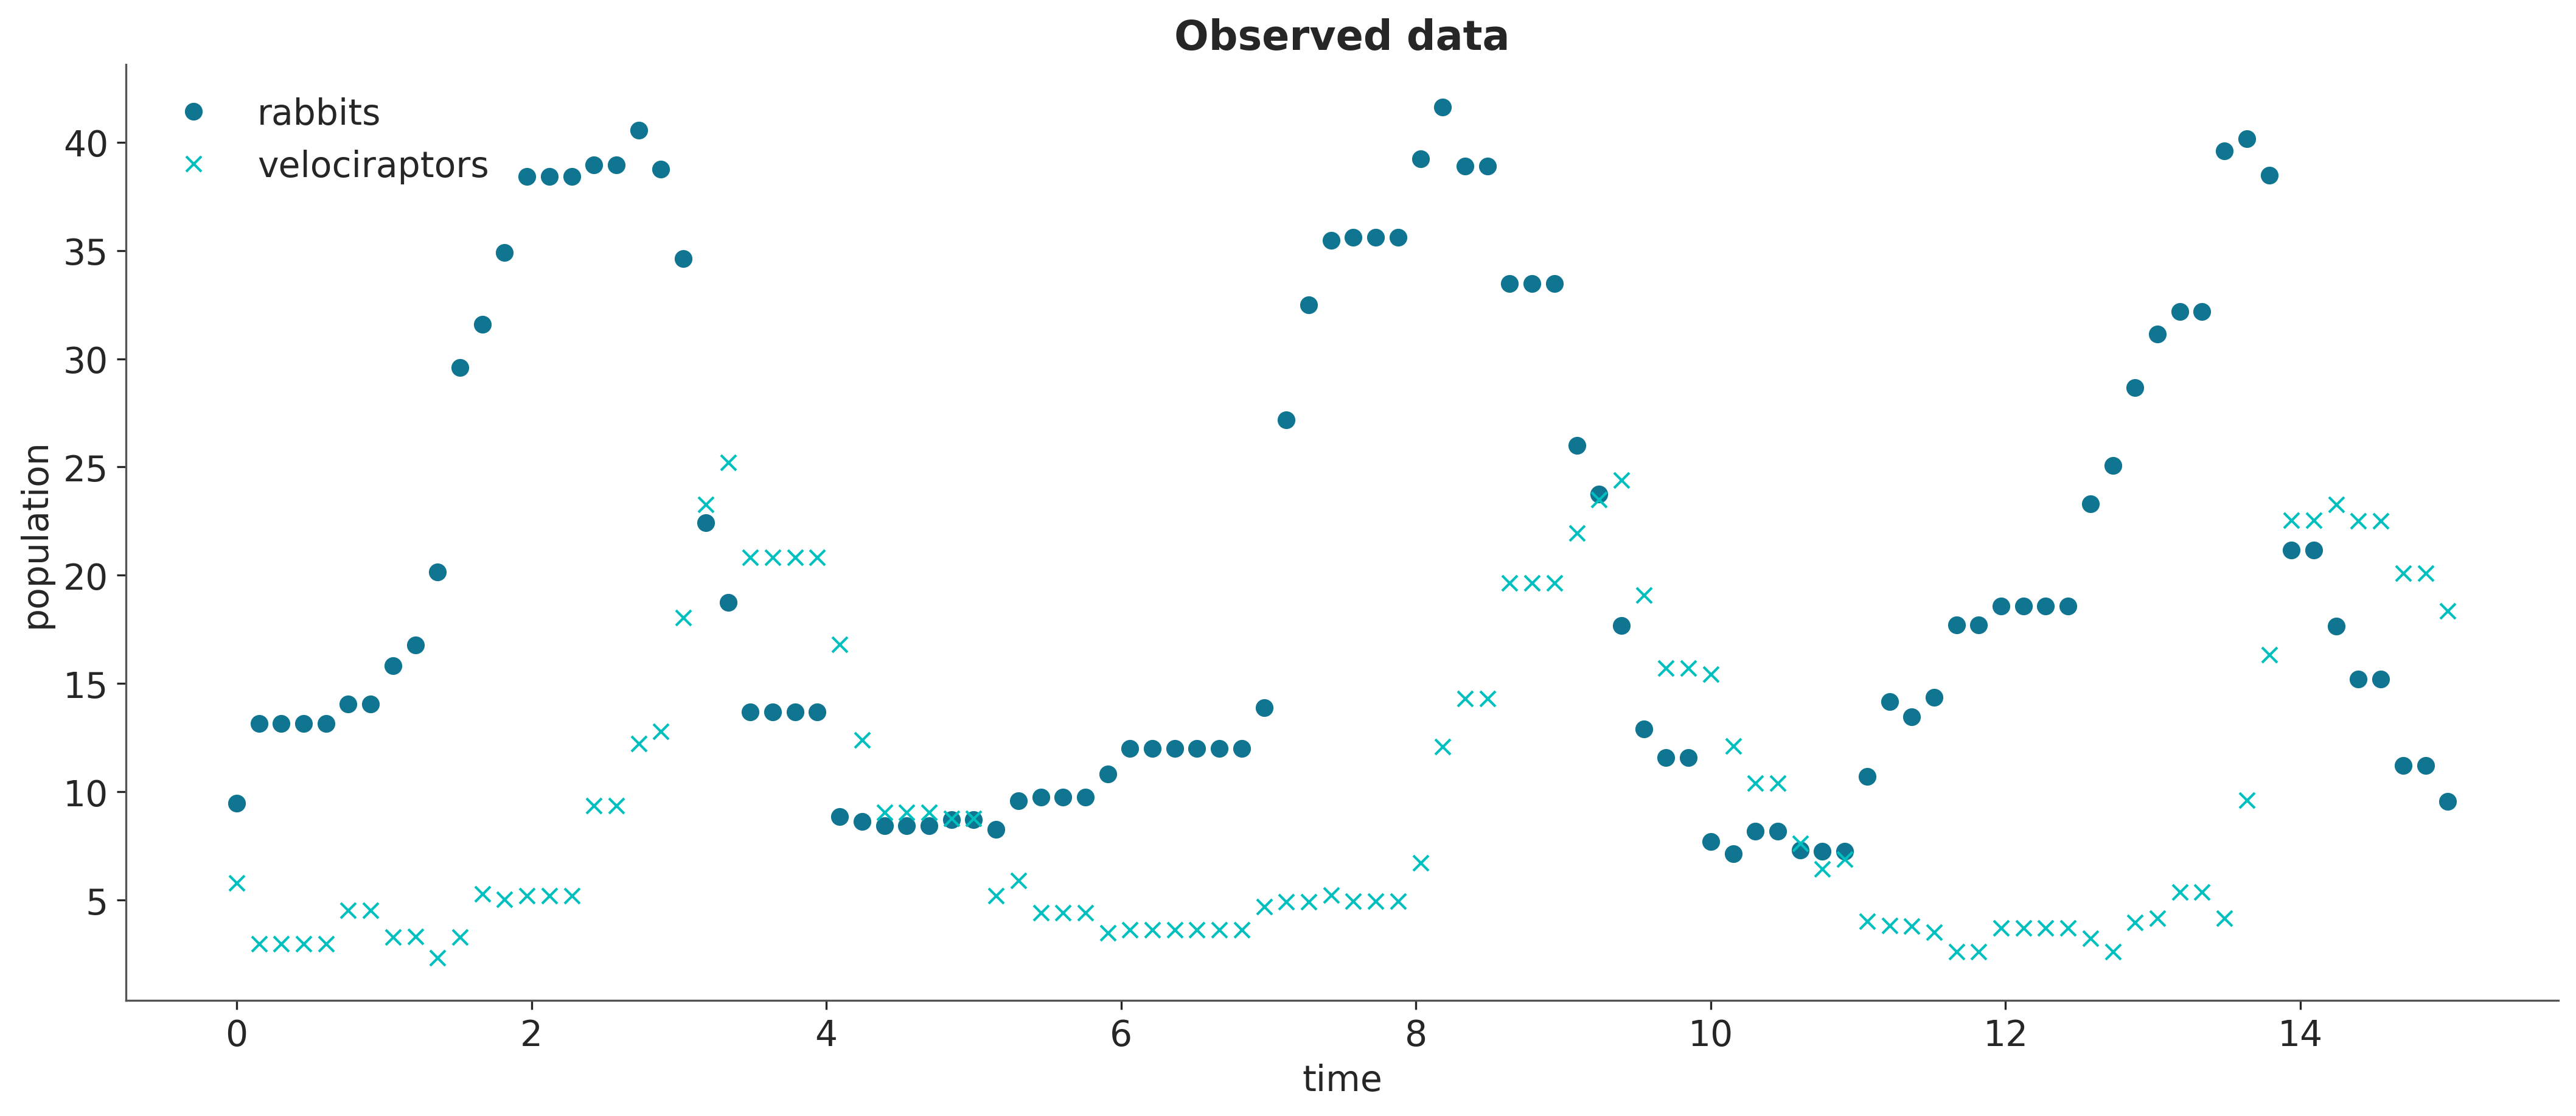

In [5]:
#| echo: false
# plotting observed data.
def plot_ode(state0, state1, title='Observed data'):
    _, ax = plt.subplots(figsize=(14, 6))
    ax.plot(t, state0, 'o', label='rabbits')
    ax.plot(t, state1, 'x', label='velociraptors')
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    ax.set_title(title)
    return ax

ax = plot_ode(observed[:,0], observed[:,1])
ax.legend()
plt.show()

## Model calibration
Since the Diffrax library is written in JAX, we can chain the numerical solution with a loss function that penalizes discrepancies between the simulations and the observations, and apply automatic differentiation on the output with JAX operators such as `jax.grad`.

To model the discrepancies, we assume that the observations are normally distributed around the simulated values, and construct a corresponding pseudolikelihood function.

In [6]:
epsilon = .5
kernel = tfd.Normal(0., epsilon)

@jit
def pseudolikelihood(x0, y0, alpha, beta, gamma, delta):
    sim_data = competition_model(x0, y0, alpha, beta, gamma, delta)
    error = observed - jnp.stack(sim_data.ys)
    return jnp.mean(kernel.log_prob(error))

To find the best fit parameters, we can then maximize this pseudolikelihood with an optimizer from the Optax library.

In [7]:
#| code-fold: true
params = jnp.array([5., 5., 1., 1., 1., 1.])

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

opt_state = optimizer.init(params)

@jit
def compute_loss(params):
    return -pseudolikelihood(*params)

# A simple update loop.
for _ in range(1000):
    grads = grad(compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

# computing the best fit solution
fitsoln = competition_model(*params)

In [8]:
#| echo: false
pd.DataFrame({'parameter':['x_0', 'y_0', 'alpha', 'beta', 'gamma', 'delta'], 'true value': list(X0) + [a, b, c, d], 'estimated value': params}).set_index('parameter')

true value  estimated value
parameter                            
x_0             10.0           10.176
y_0              5.0            3.917
alpha          1.000            0.821
beta           0.100            0.091
gamma          1.500            1.854
delta          0.075            0.095

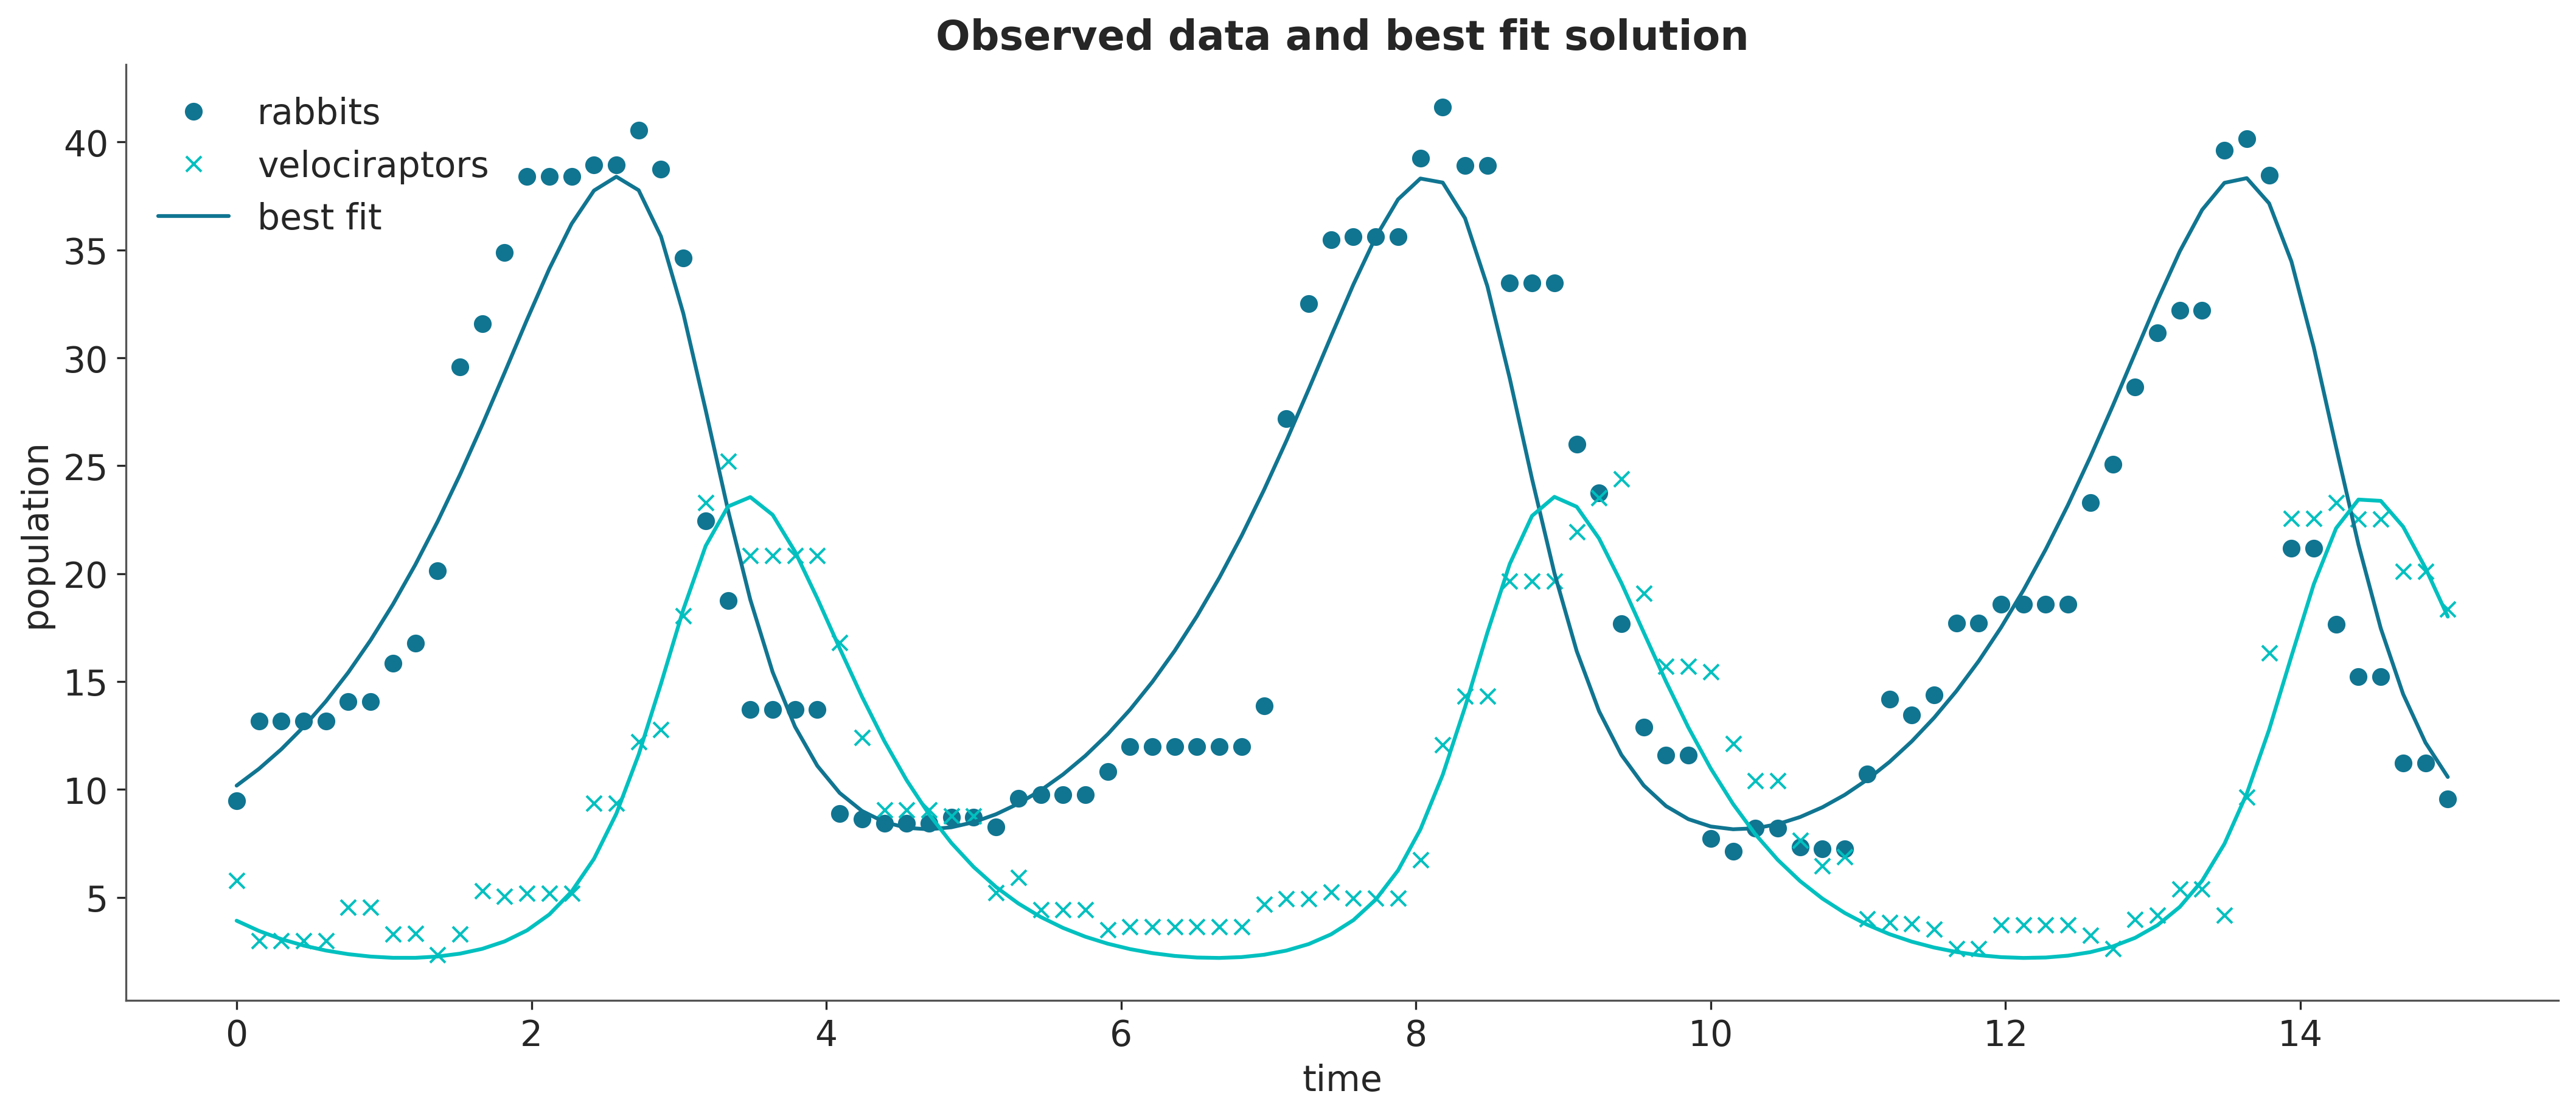

In [9]:
#| echo: false
ax = plot_ode(observed[:,0], observed[:,1], title='Observed data and best fit solution')
plt.plot(t, fitsoln.ys[:,0], color='C0', label='best fit')
plt.plot(t, fitsoln.ys[:,1], color='C1')
ax.legend()
plt.show()

## Uncertainty
The estimated values do not quite match the true parameters, and it would certainly be interesting to get error bars. A Bayesian analysis is a convenient way to achieve this, so the first step is to specify a prior distribution on the parameters.

In [10]:
ode_prior = tfd.JointDistributionSequential([
  tfd.Normal(X0[0], .25),
  tfd.Normal(X0[1], .25),
  tfd.Normal(1., .5),
  tfd.Normal(.5, .1),
  tfd.Normal(2., .5),
  tfd.Normal(1., .1),
])

Samples from the corresponding prior predictive distribution of the observed data provide a good sanity check of the choice of priors.

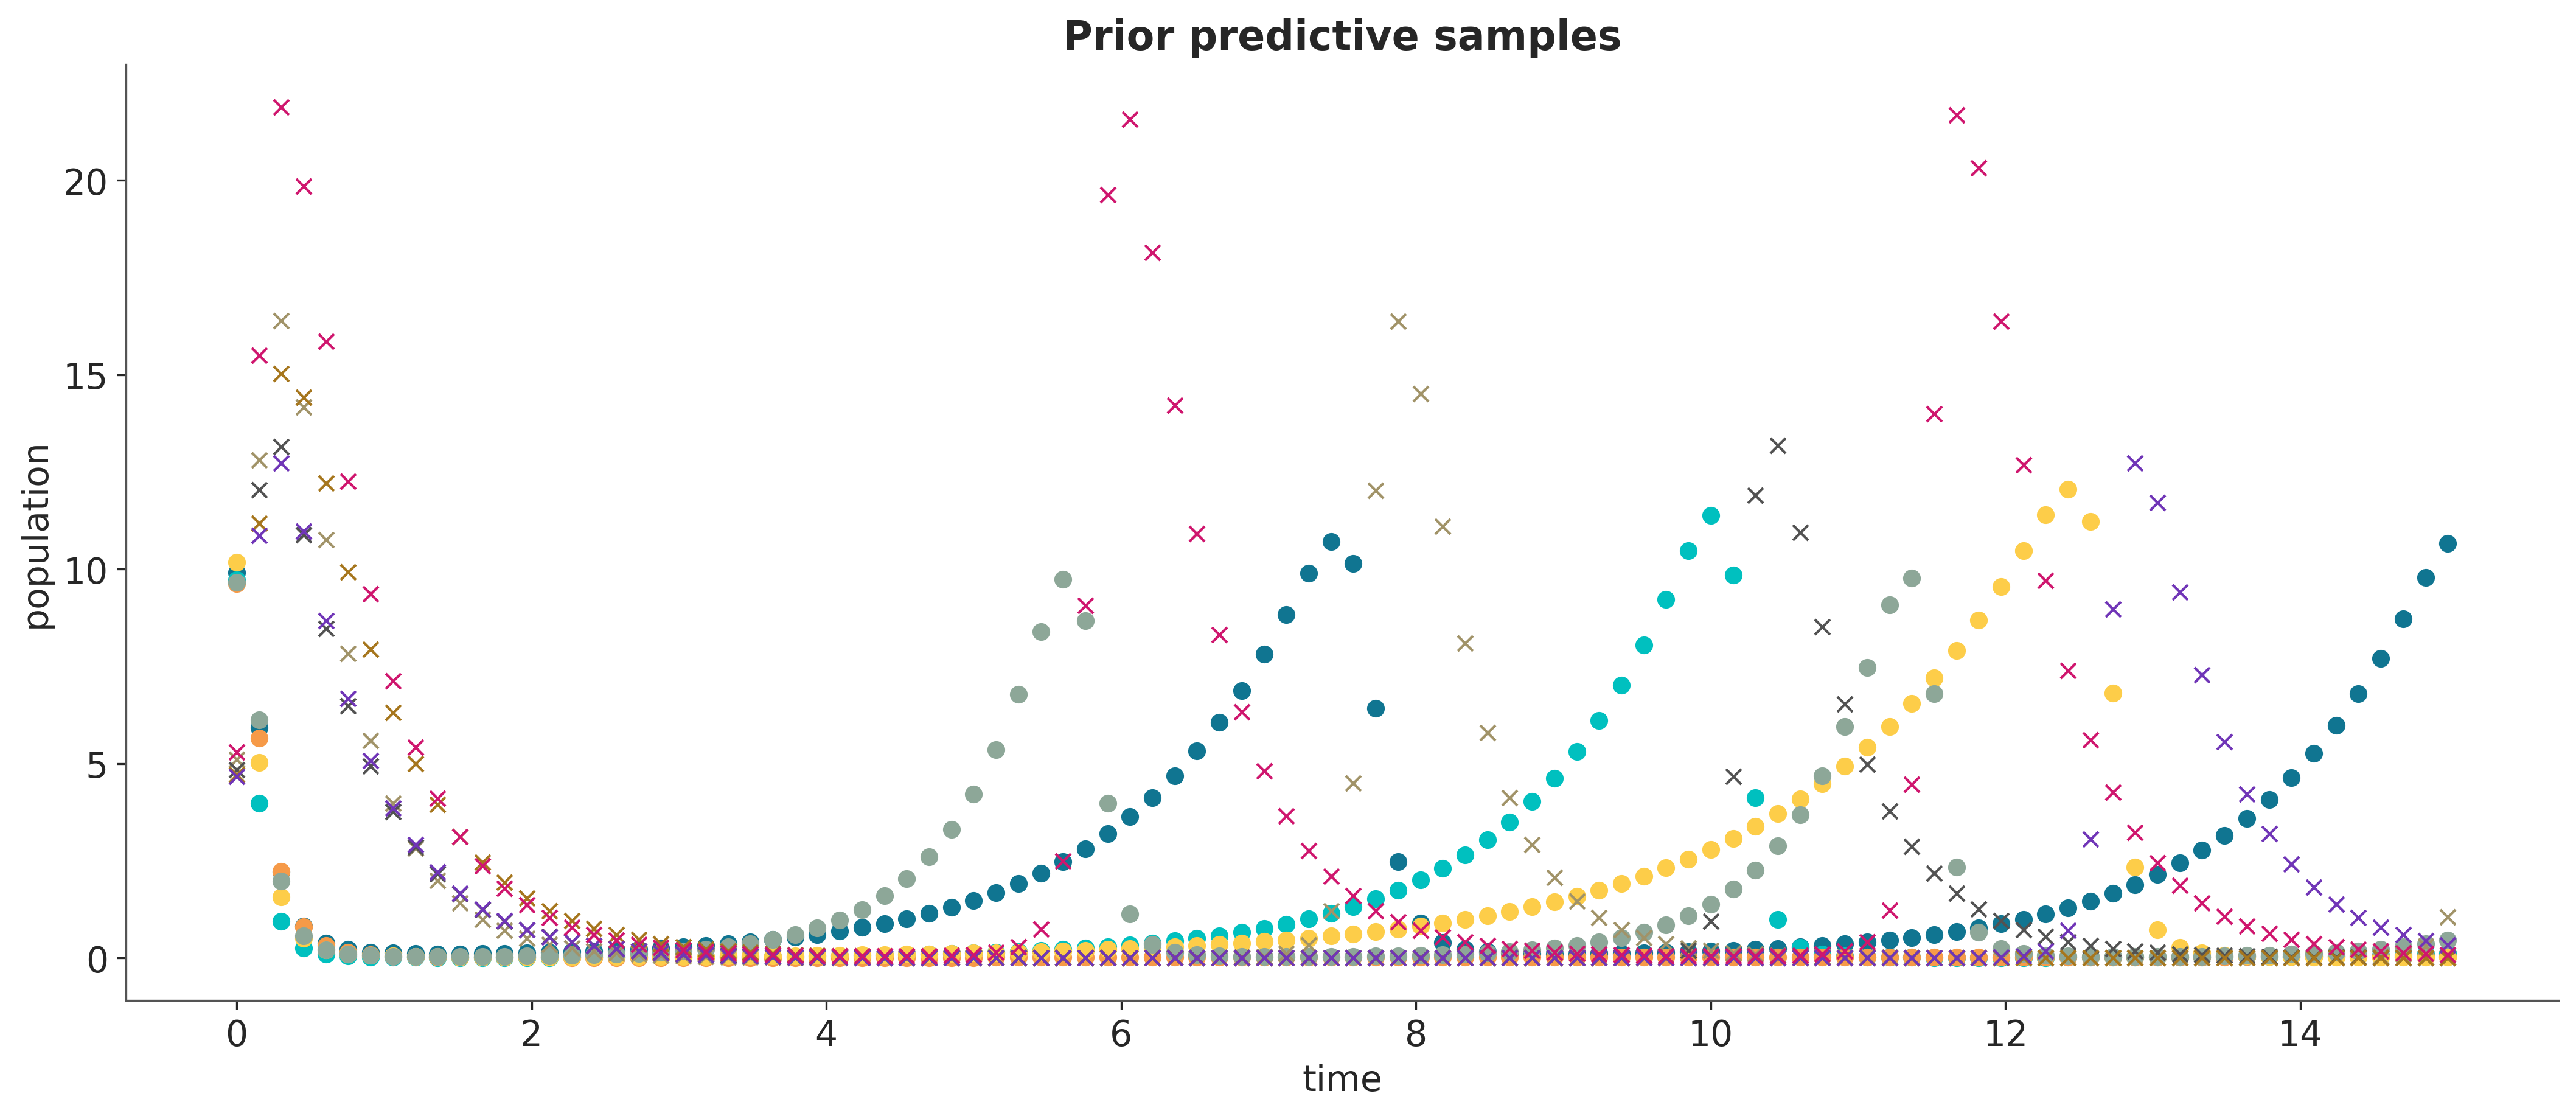

In [11]:
#| echo: false
result = competition_model(*ode_prior.sample(5, seed=sample_key))
ax = plot_ode(result.ys[:,0], result.ys[:,1], title='Prior predictive samples')
plt.show()

The problem now is that we cannot build a joint distribution of the parameters and the observations reflecting our model assumptions that there is an underlying ordinary differential equation governing the dynamic of the system. As a result, we cannot derive a likelihood function that is required by the usual MCMC and variational inference algorithms for Bayesian statistics.

As a workaround, there exist some likelihood-free inference algorithms for models where we know how to simulate data, but not how to construct a likelihood function. This is the case for a significant portion of scientific models, and the research field of [simulation-based inference](https://simulation-based-inference.org/) is growing to address this need. [Approximate Bayesian computation](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) is a family of such algorithms (see this [review article](https://www.annualreviews.org/doi/abs/10.1146/annurev-statistics-030718-105212) for more details). It includes a variant of sequential Monte Carlo (SMC) that can be implemented in PyMC and TensorFlow Probability, which we will be using here.

This algorithm requires a batched version of the pseudolikelihood function, so that it can be applied to a large sample of model parameters, the so-called particles, in parallel. For every particle, the batched pseudolikelihood function calls the differential equation solver, so a simplified version of the solver with no timestep adaptation can help avoid maximum timesteps errors.

In [12]:
@jit
def batched_competition_model(x0, y0, alpha, beta, gamma, delta):
    # solves a Lotka-Volterra system of ODEs

    def f(t, X, args):
        return jnp.array([alpha * X[0] - beta * X[0] * X[1],
                          delta * X[0] * X[1] - gamma * X[1]])
    soln = diffeqsolve(ODETerm(f), Dopri5(), t0=0, t1=time, dt0=0.1,
                       y0=jnp.array([x0, y0]), saveat=saveat)

    return soln

@jit
def batched_pseudolikelihood(x0, y0, alpha, beta, gamma, delta):
    sim_data = batched_competition_model(x0, y0, alpha, beta, gamma, delta)
    error = observed[...,jnp.newaxis] - jnp.stack(sim_data.ys)
    return jnp.mean(kernel.log_prob(error), axis=[0, 1])


A typical SMC sampler requires a prior density function and a likelihood function to build a sequence of (unnormalized) density functions between the prior and the target posterior we are interested in (for a thorough introduction to SMC algorithms, see chapter 13 of [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/)). It then applies a particle filter algorithm to get samples of these density functions until the final one provides the desired output. In SMC-ABC, the likelihood function is replaced by a pseudolikelihood function.

In [13]:
#| code-fold: true
#| output: false
sample_smc_chain = tfp.experimental.mcmc.sample_sequential_monte_carlo

@jit
def run_abc():
    n_stage, final_state, final_kernel_results = sample_smc_chain(
      prior_log_prob_fn=ode_prior.log_prob,
      likelihood_log_prob_fn=batched_pseudolikelihood,
      current_state=ode_prior.sample(1000, seed=sample_key),
      min_num_steps=5,
      seed=sample_key,
      )
    return n_stage, final_state, final_kernel_results

n_stage, final_state, final_kernel_results = run_abc()

/Users/barmazy/mambaforge/envs/myjlabenv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


The final state of the particle filter is a sample from the (approximate) posterior distribution.

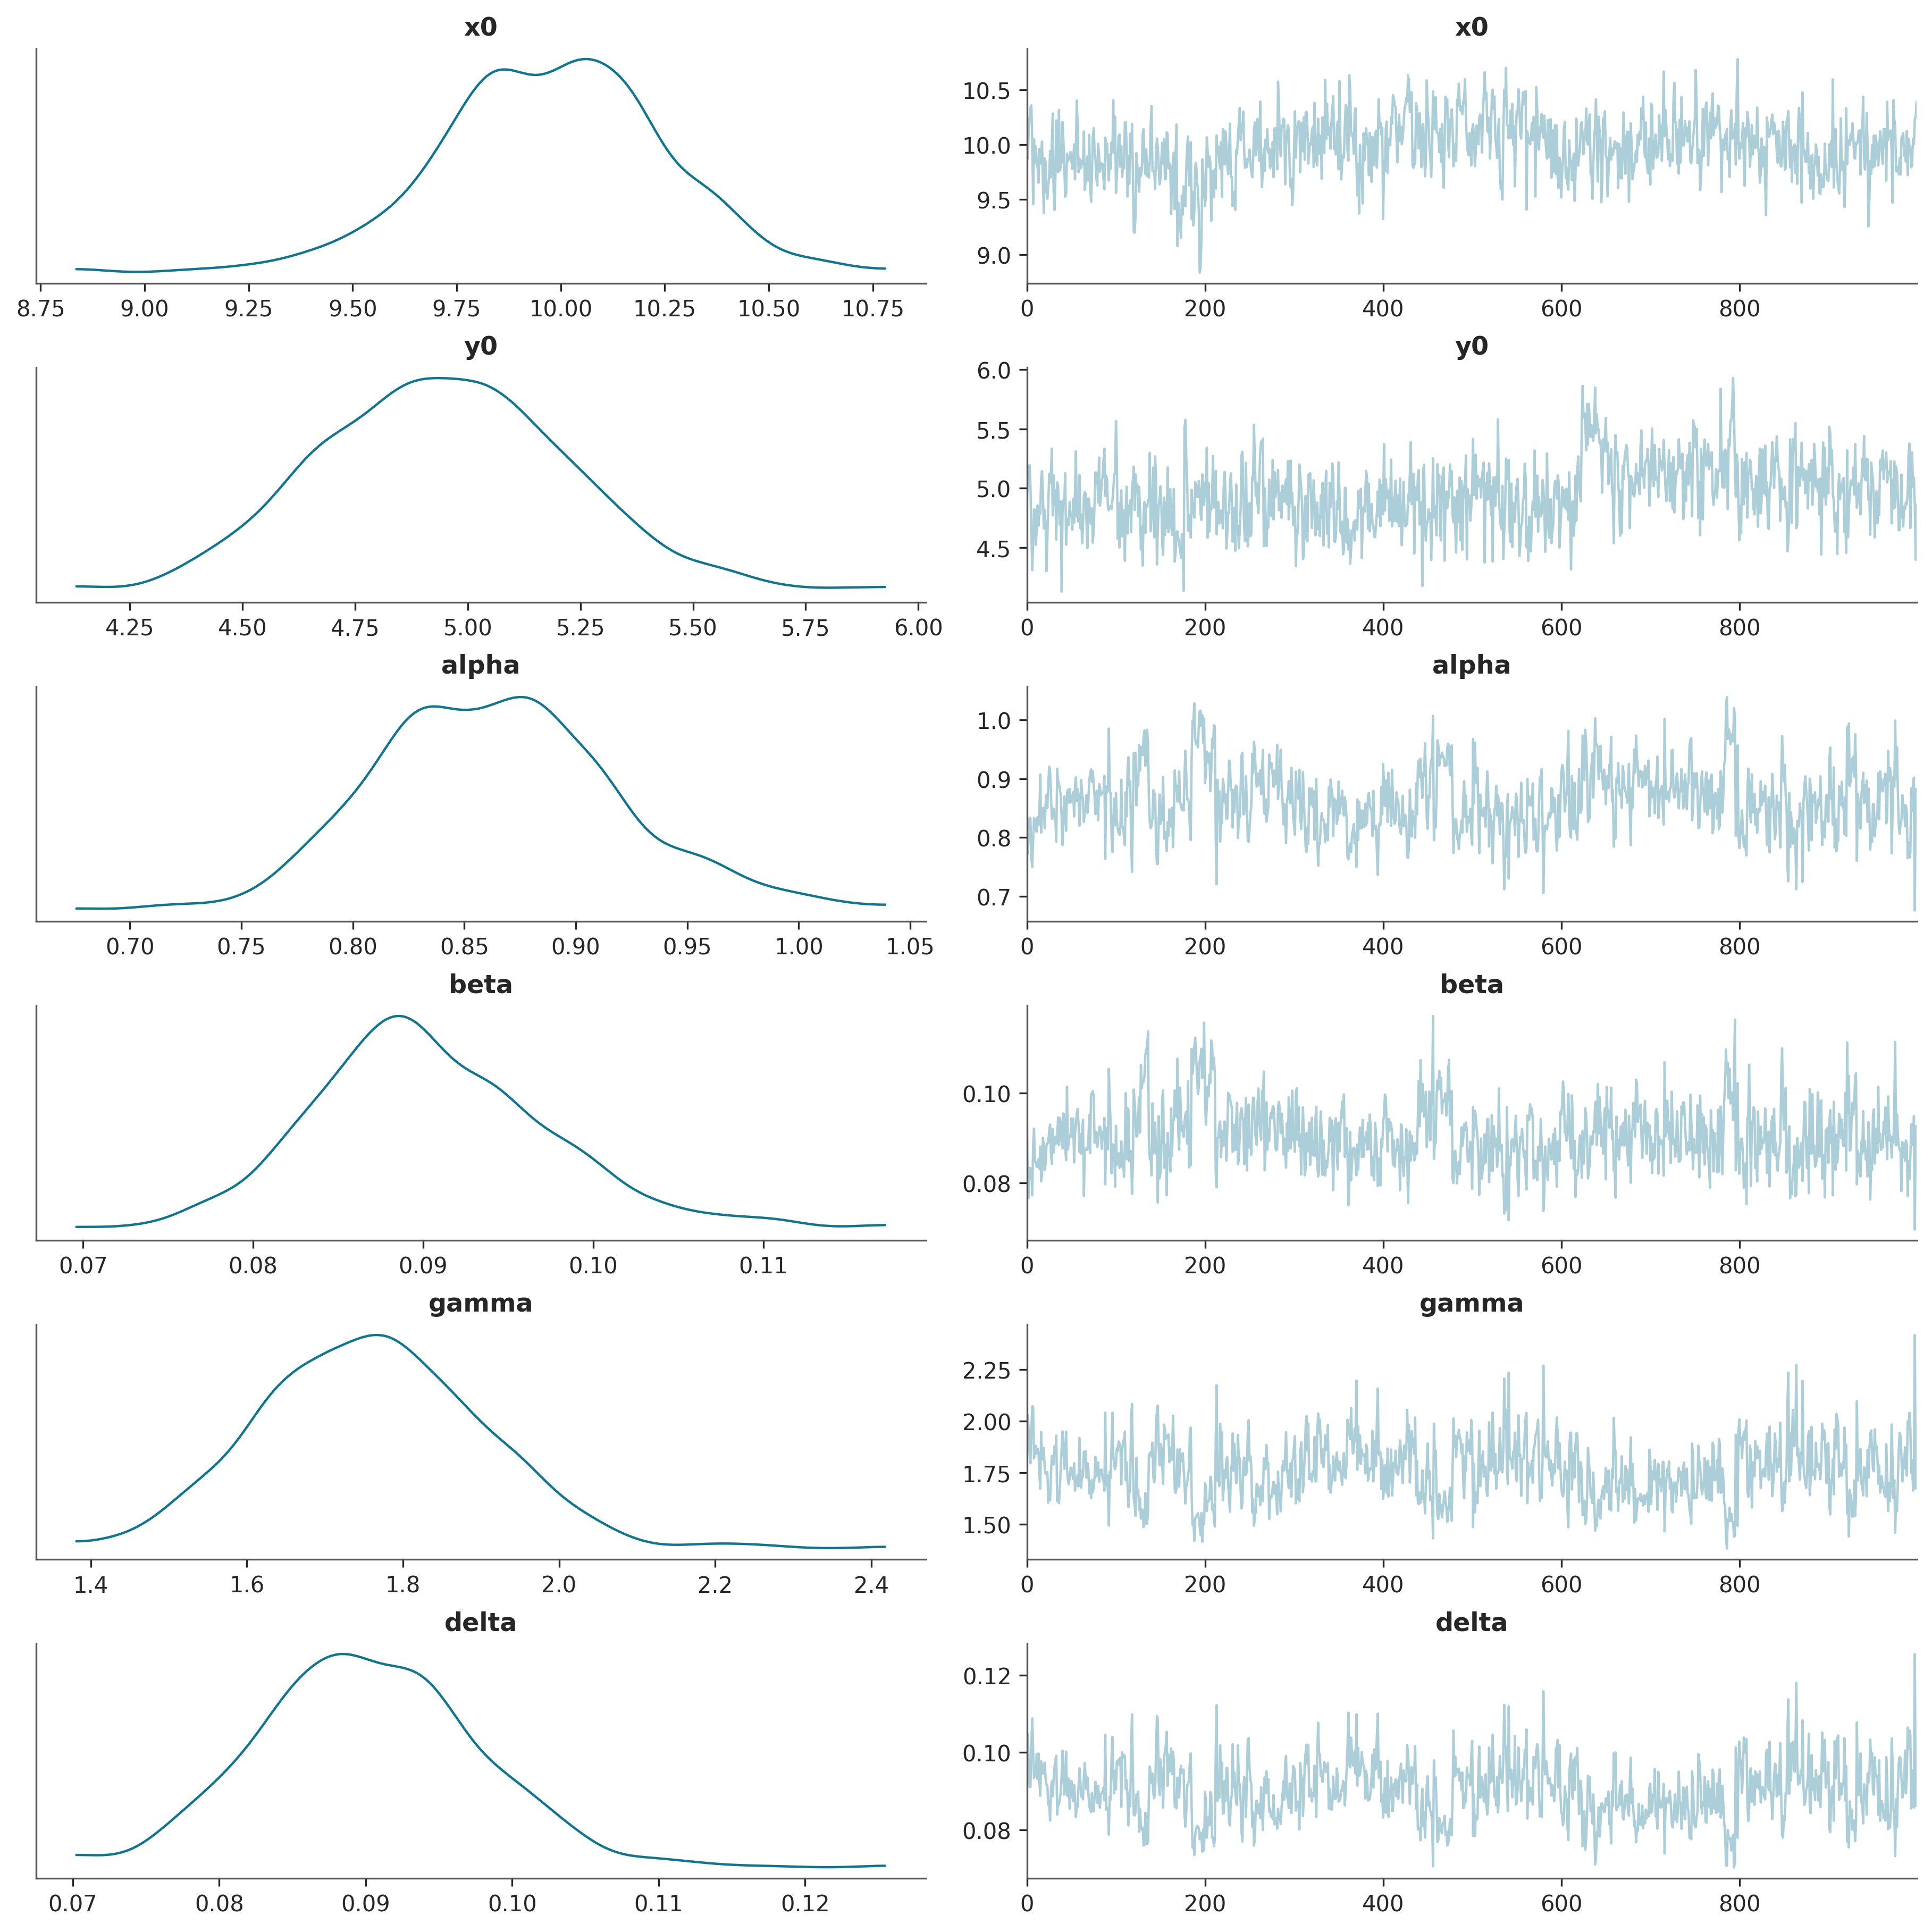

In [14]:
#| echo: false
var_name = ['x0', 'y0', 'alpha', 'beta', 'gamma', 'delta']
posterior = {k:v[jnp.newaxis, ...]
             for k, v in zip(var_name, final_state)}

az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

The posterior standard deviations provide the desired uncertainty quantification for the parameter estimates.

In [15]:
#| echo: false
pd.set_option('display.float_format',  '{:,.3f}'.format)

pd.DataFrame({'parameter':['x_0', 'y_0', 'alpha', 'beta', 'gamma', 'delta'],
              'true value': list(X0) + [a, b, c, d],
              'posterior mean': [jnp.mean(s) for s in final_state],
              'posterior std': [jnp.std(s) for s in final_state]
              }).set_index('parameter').astype('float')

true value  posterior mean  posterior std
parameter                                           
x_0            10.000           9.975          0.269
y_0             5.000           4.949          0.277
alpha           1.000           0.864          0.055
beta            0.100           0.091          0.007
gamma           1.500           1.761          0.142
delta           0.075           0.090          0.007

Lastly, we can simulate trajectories for parameters from the posterior sample to visualize the posterior predictive distribution of populations and compare it with the observations.

In [16]:
#| echo: false
posterior_predictive = jnp.stack(competition_model(*final_state).ys)

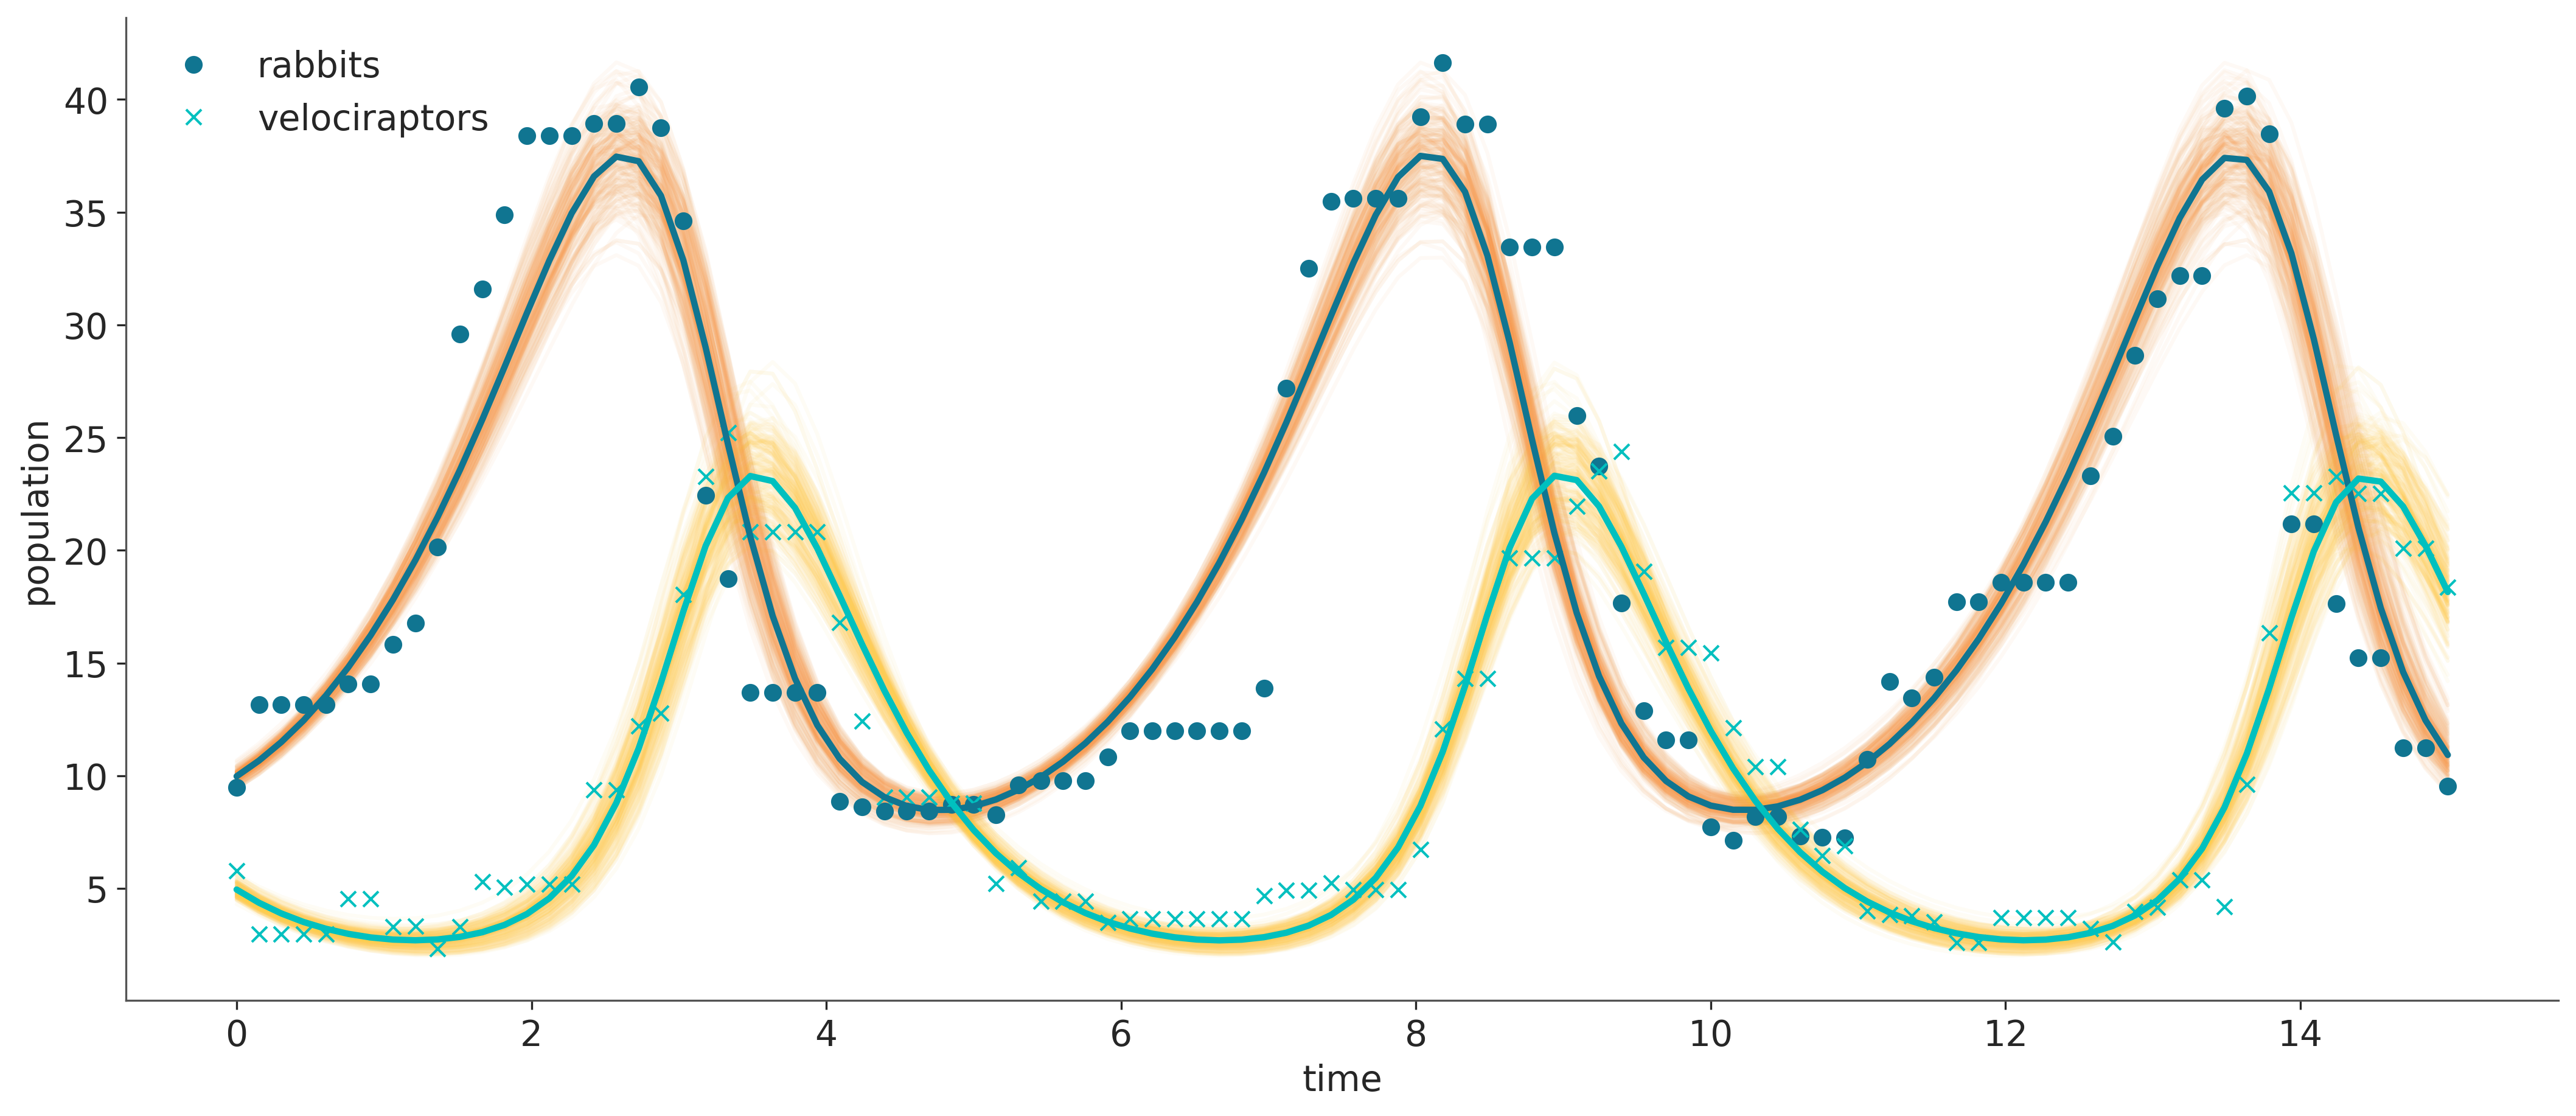

In [17]:
#| echo: false
_, ax = plt.subplots(figsize=(14,6))
ax.plot(t, observed[:, 0], 'o', label='rabbits', c='C0')
ax.plot(t, observed[:, 1], 'x', label='velociraptors', c='C1')

posterior_mean = jnp.mean(posterior_predictive, axis=-1)
ax.plot(t, posterior_mean[:,0], c='C0', linewidth=2.5)
ax.plot(t, posterior_mean[:,1], c='C1', linewidth=2.5)

for i in random.randint(sample_key, (200,), 0, 1000):
    ax.plot(t, posterior_predictive[:, 0, i], alpha=0.05, c='C2', zorder=0)
    ax.plot(t, posterior_predictive[:, 1, i], alpha=0.05, c='C3', zorder=0)
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend()
plt.show()